In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wastex
Your Kaggle Key: ········


  1%|          | 4.00M/395M [00:00<00:11, 37.1MB/s]

100%|██████████| 395M/395M [00:05<00:00, 80.1MB/s] 


In [3]:
import os

data_dir = './animefacedataset'
print(os.listdir(data_dir))

['images']


In [4]:
print(os.listdir(data_dir+'/images')[:10])

['50896_2015.jpg', '62198_2019.jpg', '41692_2013.jpg', '14166_2006.jpg', '37335_2012.jpg', '6653_2003.jpg', '23409_2008.jpg', '35885_2011.jpg', '32498_2011.jpg', '37690_2012.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch.nn.functional as F

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

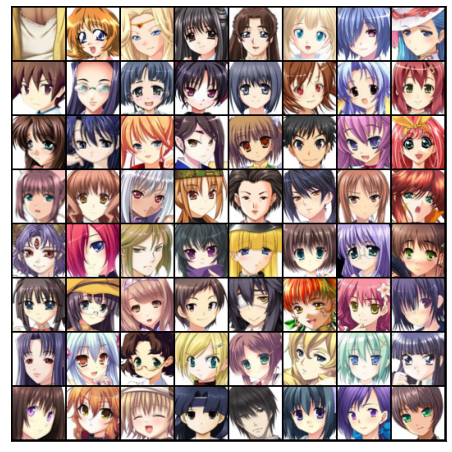

In [11]:
show_batch(train_dl)

# Translating to GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [14]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator network

In [15]:
import torch.nn as nn

In [16]:
discriminator = nn.Sequential(
    # input: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

# Generator Network

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # input: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # outL 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


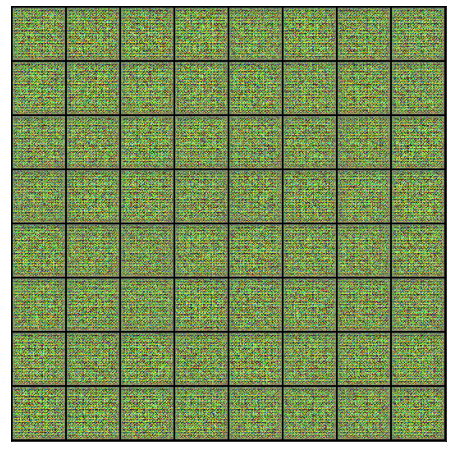

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

# Dicriminator training


In [22]:
def train_discriminator(real_images, opt_d):
  # clear discriminator gradients
  opt_d.zero_grad()

  # pass real images throught discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  
  return loss.item(), real_score, fake_score

# Generator training

In [23]:
def train_generator(opt_g):
  # clear generator gradients
  opt_g.zero_grad()

  # generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [24]:
from torchvision.utils import save_image

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


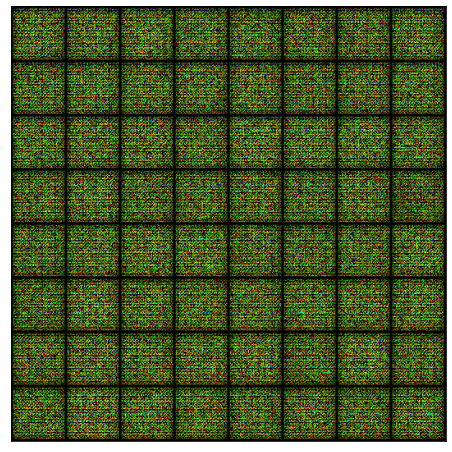

In [28]:
save_samples(0, fixed_latent)

#Full trainig loop

In [29]:
from tqdm.notebook import tqdm

In [30]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  # losses & scores
  losses_g, losses_d, real_scores, fake_scores = [], [], [], []

  # create optimizer
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # train generator
      loss_g = train_generator(opt_g)

    # record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # log losses & scores (last batch)
    print('Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}'.format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    # save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [31]:
lr = 0.0002
epochs = 50

In [32]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 4.2535, loss_d: 0.5055, real_score: 0.7981, fake_score: 0.2170
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 6.2347, loss_d: 0.2309, real_score: 0.8330, fake_score: 0.0121
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.7636, loss_d: 0.1836, real_score: 0.8552, fake_score: 0.0053
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.1062, loss_d: 0.1251, real_score: 0.9235, fake_score: 0.0339
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 5.0766, loss_d: 0.2456, real_score: 0.8475, fake_score: 0.0375
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.2170, loss_d: 0.0921, real_score: 0.9604, fake_score: 0.0445
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 9.7725, loss_d: 0.2526, real_score: 0.9798, fake_score: 0.1849
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 7.1098, loss_d: 0.1379, real_score: 0.9525, fake_score: 0.0776
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 12.5794, loss_d: 0.0553, real_score: 0.9539, fake_score: 0.0001
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 7.7816, loss_d: 0.0251, real_score: 0.9778, fake_score: 0.0005
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 23.4534, loss_d: 1.0786, real_score: 0.9994, fake_score: 0.4403
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 6.0635, loss_d: 0.0529, real_score: 0.9678, fake_score: 0.0145
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 9.0168, loss_d: 0.1827, real_score: 0.9555, fake_score: 0.1142
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.6736, loss_d: 0.0705, real_score: 0.9850, fake_score: 0.0477
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.1725, loss_d: 0.0883, real_score: 0.9677, fake_score: 0.0404
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 14.8954, loss_d: 0.6515, real_score: 0.7025, fake_score: 0.0000
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 7.2285, loss_d: 0.0427, real_score: 0.9872, fake_score: 0.0285
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 6.9541, loss_d: 0.0575, real_score: 0.9644, fake_score: 0.0040
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 5.6818, loss_d: 0.0521, real_score: 0.9692, fake_score: 0.0179
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 8.7278, loss_d: 0.0561, real_score: 0.9546, fake_score: 0.0034
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 16.6212, loss_d: 0.0325, real_score: 0.9868, fake_score: 0.0167
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 10.7601, loss_d: 0.1362, real_score: 0.9996, fake_score: 0.1215
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 9.7732, loss_d: 0.1186, real_score: 0.9601, fake_score: 0.0580
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 11.4108, loss_d: 0.1498, real_score: 0.9999, fake_score: 0.1101
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 6.7519, loss_d: 0.0614, real_score: 0.9620, fake_score: 0.0099
Saving generated-images-0025.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 11.0117, loss_d: 0.0853, real_score: 0.9398, fake_score: 0.0011
Saving generated-images-0026.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 6.1350, loss_d: 0.0692, real_score: 0.9800, fake_score: 0.0435
Saving generated-images-0027.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.4874, loss_d: 0.0359, real_score: 0.9890, fake_score: 0.0239
Saving generated-images-0028.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 10.2995, loss_d: 0.1253, real_score: 0.9755, fake_score: 0.0884
Saving generated-images-0029.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 13.7907, loss_d: 0.1366, real_score: 0.9982, fake_score: 0.1002
Saving generated-images-0030.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 9.2968, loss_d: 0.0914, real_score: 0.9806, fake_score: 0.0662
Saving generated-images-0031.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.6522, loss_d: 0.0940, real_score: 0.9620, fake_score: 0.0336
Saving generated-images-0032.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.9692, loss_d: 0.0893, real_score: 0.9551, fake_score: 0.0275
Saving generated-images-0033.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 7.6809, loss_d: 0.0200, real_score: 0.9894, fake_score: 0.0088
Saving generated-images-0034.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 14.2147, loss_d: 0.0883, real_score: 0.9389, fake_score: 0.0079
Saving generated-images-0035.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.9642, loss_d: 0.1308, real_score: 0.9313, fake_score: 0.0371
Saving generated-images-0036.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 22.2179, loss_d: 0.0466, real_score: 0.9799, fake_score: 0.0037
Saving generated-images-0037.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 32.6202, loss_d: 0.4149, real_score: 0.8397, fake_score: 0.0000
Saving generated-images-0038.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.8940, loss_d: 0.0707, real_score: 0.9642, fake_score: 0.0241
Saving generated-images-0039.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 32.2462, loss_d: 0.0658, real_score: 1.0000, fake_score: 0.0555
Saving generated-images-0040.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 38.3323, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0041.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 9.3434, loss_d: 0.0846, real_score: 0.9670, fake_score: 0.0011
Saving generated-images-0042.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 17.6438, loss_d: 0.2904, real_score: 0.8537, fake_score: 0.0000
Saving generated-images-0043.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 6.5887, loss_d: 0.0431, real_score: 0.9742, fake_score: 0.0137
Saving generated-images-0044.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.8580, loss_d: 0.0041, real_score: 0.9976, fake_score: 0.0017
Saving generated-images-0045.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 8.8665, loss_d: 0.0619, real_score: 0.9993, fake_score: 0.0546
Saving generated-images-0046.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 11.2356, loss_d: 0.0251, real_score: 0.9772, fake_score: 0.0006
Saving generated-images-0047.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 17.7675, loss_d: 0.0326, real_score: 0.9861, fake_score: 0.0158
Saving generated-images-0048.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 7.0276, loss_d: 0.0206, real_score: 0.9882, fake_score: 0.0079
Saving generated-images-0049.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 9.8749, loss_d: 0.0036, real_score: 1.0000, fake_score: 0.0036
Saving generated-images-0050.png


In [33]:
from IPython.display import Image

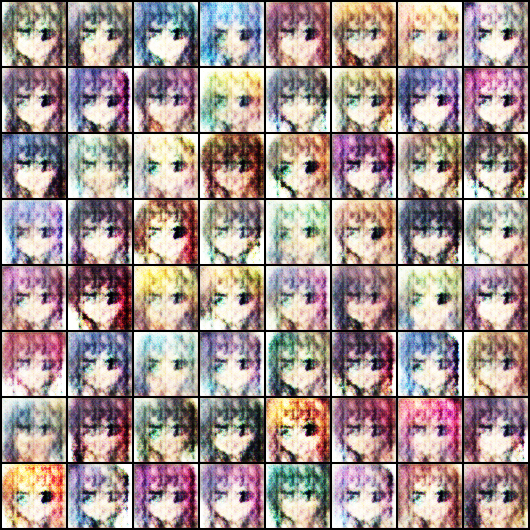

In [34]:
Image('./generated/generated-images-0001.png')

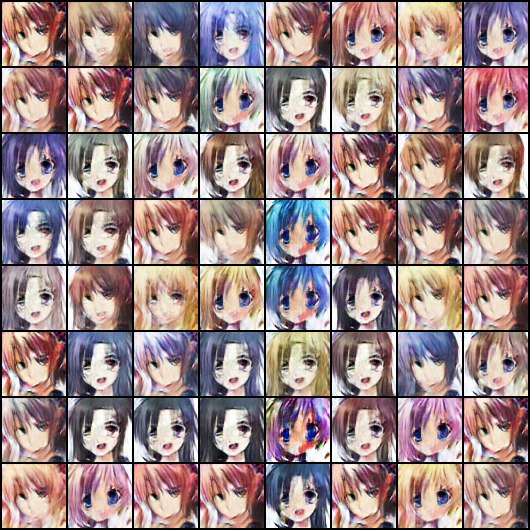

In [35]:
Image('./generated/generated-images-0025.png')

In [ ]:
Image('./generated/generated-images-0045.png')

# Save the model

In [36]:
torch.save(discriminator.state_dict(), 'discriminator.ckpt')
torch.save(generator.state_dict(), 'generator.ckpt')

# Convert images to video

In [37]:
import cv2
import os

vid_fname = 'gans_training.avi'
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 4, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

# Graphics

Text(0.5, 1.0, 'Losses')

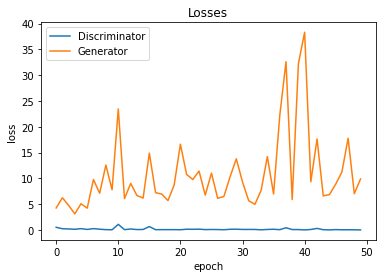

In [38]:
plt.plot(history[1], '-')
plt.plot(history[0], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

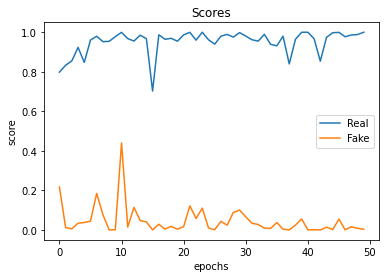

In [39]:
plt.plot(history[2], '-')
plt.plot(history[3], '-')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')